In [58]:
#Importing the relevant libraries

import re
import pandas as pd
from nltk import word_tokenize
from collections import Counter
from nltk.corpus import stopwords
from sklearn.metrics import f1_score
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score
from yellowbrick.classifier import ROCAUC
from yellowbrick.datasets import load_game
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [59]:
clf = AdaBoostClassifier(random_state=42)
clf_1 = MultinomialNB()
clf_2 = GaussianNB()

parameters = {'n_estimators':[400, 500, 600],'learning_rate':[1, 2, 3]}
parameters_1 = {'alpha': [0.1, 1, 1.5, 2, 3, 5], 'fit_prior': [True, False]}
parameters_2 = {'var_smoothing': [1e-9, 1e-3, 1e-6, 1, 2]}

#GridSearchCV function that returns the best classifier


def calculate_F1_Score(model, parameters, Train_features, Train_labels, Test_features, Test_labels):
    scorer = make_scorer(f1_score, average = 'macro')
    grid_ = GridSearchCV(model, parameters, scoring=scorer)
    fit = grid_.fit(Train_features.toarray(), Train_labels)
    best_classifier = fit.best_estimator_

    # Fit the new model.
    best_classifier.fit(Train_features.toarray(), Train_labels)
    best_predictions_1 = best_classifier.predict(Train_labels.toarray())
    best_predictions_2 = best_classifier.predict(Test_labels.toarray())

    # Calculate the f1_score of the new model.
    print('The training F1 Score is', f1_score(best_predictions_1, Train_labels, average = 'macro'))
    print('The testing F1 Score is', f1_score(best_predictions_2, Test_labels, average = 'macro'))
    print(best_classifier)


In [2]:
#Function to read file as csv

def read_file(filepath):
    file = pd.read_csv(filepath, encoding = 'latin-1')
    return file

In [3]:
#Merging sentiments and reducing them from 5 to 3

def merge_sentiments(label):
    if label == "Positive":
        return '1'
    elif label == 'Extremely Positive':
        return '1'
    elif label == "Negative":
        return '2'
    elif label == 'Extremely Negative':
        return '2'
    else:
        return '0'

In [23]:
#Checking the percentages of different sentiments

def get_proportions(dataset):
    
    # summarize the class distribution
    target = dataset['Sentiment']
    counter = Counter(target)
    for k,v in counter.items():
        per = v / len(target) * 100
        print( (k,'has', per, 'percent of the dataset'))

In [7]:
#Basic text preprocessing function that normalizes and cleans the text

def preprocess(text):
    from nltk.corpus import stopwords
    stopwords = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()

    url_free = re.compile(r'https?://\S+|www\.\S+').sub(r'', text)
    #url_free = url_free.
    
    html_free = re.compile(r'<.*?>').sub(r'', url_free)
    #html_free = html_free.

    lower_case = html_free.lower()

    number_free = re.sub(r'\d+', '', lower_case)

    punct_free = re.sub(r"[^\w\s\d]","", number_free)

    mention_free = re.sub(r'@\w+','', punct_free)

    hash_free = text=re.sub(r'#\w+','', mention_free)

    space_free = re.sub(r"\s+"," ", hash_free).strip()

    stopwords_free = " ".join([word for word in str(space_free).split() if word not in stopwords])

    word_tokenized = word_tokenize(stopwords_free, language='english')

    lemmatized = [lemmatizer.lemmatize(t) for t in word_tokenized]
    
    return lemmatized

In [29]:
#Getting different classification metrics for different models

def get_metrics(model, train_features, train_label, test_features, test_label):
    test_preds = model.predict(test_features)
    train_preds = model.predict(train_features)

    print(model)
    print('Test F1 score =', f1_score(test_label, test_preds, average = 'weighted'))
    print('Train F1 score =', f1_score(train_label, train_preds, average = 'weighted'))
    print('Accuracy score =', accuracy_score(test_label, test_preds))
    print('Precision score =', precision_score(test_label, test_preds, average = 'weighted'))
    print('Recall score =', recall_score(test_label, test_preds, average = 'weighted'))
    print()

In [39]:
#Plotting ROC curves for each model

def get_ROC_curves(model, Train_features, Train_labels, Test_features, Test_labels):
    from yellowbrick.classifier import ROCAUC
    visualizer = ROCAUC(model, classes=["Positive", "Negative", "Neutral"])
    visualizer.fit(Train_features, Train_labels)       
    visualizer.score(Test_features, Test_labels)        
    visualizer.show();      

In [38]:
#Plotting the AUC curves for different models

def get_precision_curves(model, Train_features, Train_labels, Test_features, Test_labels):
    from yellowbrick.classifier import PrecisionRecallCurve
    visualizer = PrecisionRecallCurve(model, colors=["yellow", "green", "red"], iso_f1_curves=True, per_class=True, micro=False)
    visualizer.fit(Train_features, Train_labels)
    visualizer.score(Test_features, Test_labels)
    visualizer.show();

In [40]:
#Plotting the confusion matrix for each of the models

def get_confusion_matrix(model, Train_features, Train_labels, Test_features, Test_labels):
    from yellowbrick.classifier import ConfusionMatrix
    matrix = ConfusionMatrix(model, classes=['Neutral',"Positive", 'Negative'])
    matrix.fit(Train_features, Train_labels)
    matrix.score(Test_features, Test_labels)
    matrix.show();

## IMPORTING AND PREPROCESSING

In [14]:
#Importing training and test files as Pandas dataframes

train_set = read_file("C:\\Users\\Ahmad Wali\\Desktop\\Corona_NLP_train.csv")
test_set = read_file("C:\\Users\\Ahmad Wali\\Desktop\\Corona_NLP_test.csv")

In [15]:
#Merging the sentiment values in the train and test sets and assigning numerical values to them
#The sentiments values will be used as labels for the tasks.

for i in range(0, len(train_set['Sentiment'])):
    train_set['Sentiment'][i] = merge_sentiments(train_set['Sentiment'][i])

for i in range(0, len(test_set['Sentiment'])):
    test_set['Sentiment'][i] = merge_sentiments(test_set['Sentiment'][i])

C:\Users\Ahmad Wali\anaconda3\envs\Random_Stuff\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Ahmad Wali\anaconda3\envs\Random_Stuff\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [16]:
#Preprocessing the tweet columns for the train and test sets. These will be used 
#as the features.

for i in range(0, len(train_set['OriginalTweet'])):
    train_set['OriginalTweet'][i] = preprocess(train_set['OriginalTweet'][i])

for i in range(0, len(test_set['OriginalTweet'])):
    test_set['OriginalTweet'][i] = preprocess(test_set['OriginalTweet'][i])

C:\Users\Ahmad Wali\anaconda3\envs\Random_Stuff\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Ahmad Wali\anaconda3\envs\Random_Stuff\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [18]:
#Basic EDA on the dataset
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [24]:
get_proportions(train_set)

('0', 'has', 18.740432976164442, 'percent of the dataset')
('1', 'has', 43.84673324100396, 'percent of the dataset')
('2', 'has', 37.4128337828316, 'percent of the dataset')


In [20]:
train_set.isna().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [21]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


In [25]:
get_proportions(test_set)

('2', 'has', 42.99631384939442, 'percent of the dataset')
('1', 'has', 40.7056345444971, 'percent of the dataset')
('0', 'has', 16.298051606108476, 'percent of the dataset')


In [27]:
test_set.isna().sum()

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

## MODELS FEATURE TYPE 1

In [33]:
#Creating a TF-IDF vectorizer and fitting it to the training features. The test features
#are transformed against this.

vectorizer = TfidfVectorizer(sublinear_tf = True, min_df = 5, lowercase = False)

Train_features = vectorizer.fit_transform(train_set['OriginalTweet'].astype(str))
Train_labels = train_set['Sentiment']

Test_features = vectorizer.transform(test_set['OriginalTweet'].astype(str))
Test_labels = test_set['Sentiment']

#### Gaussian Naive Bayes

GaussianNB()
Test F1 score = 0.3922158427792363
Train F1 score = 0.5094601623097834
Accuracy score = 0.38256977356503424
Precision score = 0.5632089209277557
Recall score = 0.38256977356503424



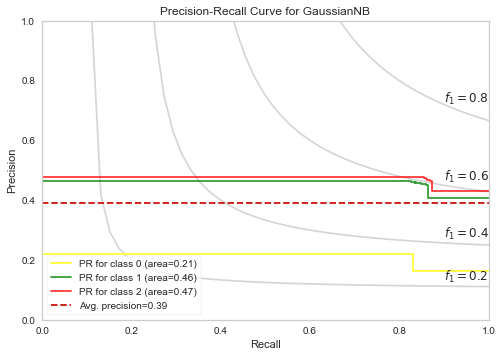

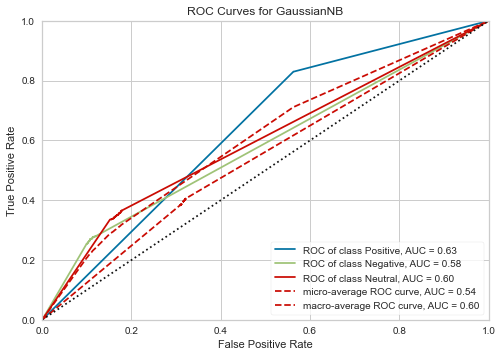

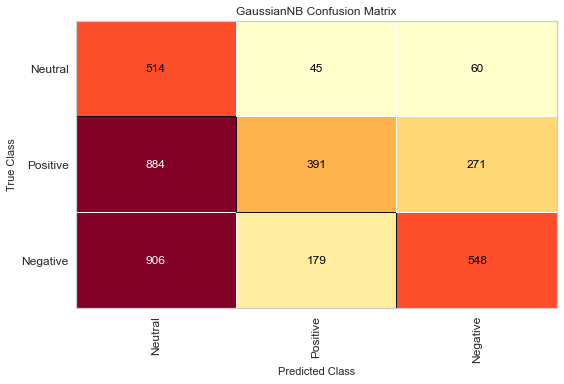

In [44]:
#Creating a Gaussian naive Bayes classifier that will be used as a baseline.
#Metrics for the model will also be obtained.

gaussian_clf = GaussianNB()
gaussian_clf.fit(Train_features.toarray(), Train_labels)
get_metrics(gaussian_clf, Train_features.toarray(),Train_labels, Test_features.toarray(), Test_labels)
get_precision_curves(gaussian_clf, Train_features.toarray(),Train_labels, Test_features.toarray(), Test_labels)
get_ROC_curves(gaussian_clf, Train_features.toarray(),Train_labels, Test_features.toarray(), Test_labels)
get_confusion_matrix(gaussian_clf, Train_features.toarray(), Train_labels, Test_features.toarray(), Test_labels)

#### Multinomial Naive Bayes Classifier

MultinomialNB(alpha=3, fit_prior=False)
Test F1 score = 0.6697380829995985
Train F1 score = 0.7417615408151426
Accuracy score = 0.6843075302790943
Precision score = 0.6742707981212451
Recall score = 0.6843075302790943



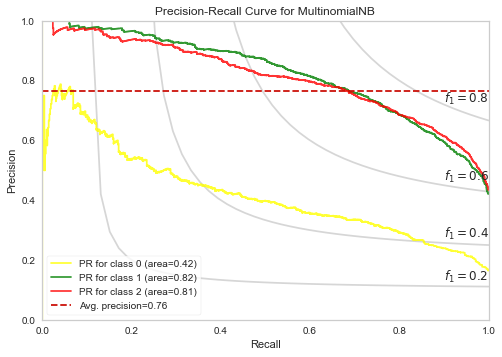

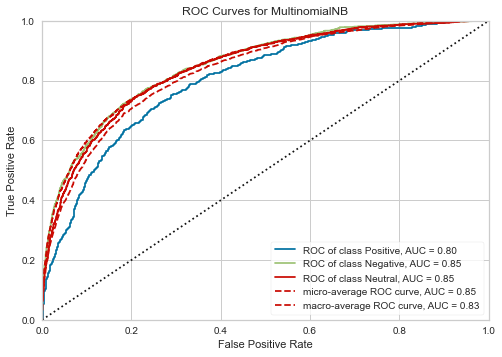

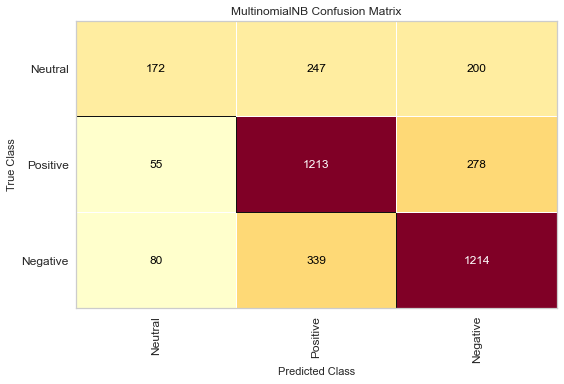

In [45]:
#Creating another model as MultinomialNB that is fitted with the recommended parameters
#obtained from Gridsearch.

multinomial_clf = MultinomialNB(alpha = 3, fit_prior= False)
multinomial_clf.fit(Train_features, Train_labels)
get_metrics(multinomial_clf, Train_features,Train_labels, Test_features, Test_labels)
get_precision_curves(multinomial_clf, Train_features,Train_labels, Test_features, Test_labels)
get_ROC_curves(multinomial_clf, Train_features,Train_labels, Test_features, Test_labels)
get_confusion_matrix(multinomial_clf, Train_features, Train_labels, Test_features, Test_labels)

#### AdaBoost Classifier

AdaBoostClassifier(learning_rate=1, n_estimators=600)
Test F1 score = 0.7626490179786424
Train F1 score = 0.8070176795023631
Accuracy score = 0.7596103212216956
Precision score = 0.7730298985794806
Recall score = 0.7596103212216956



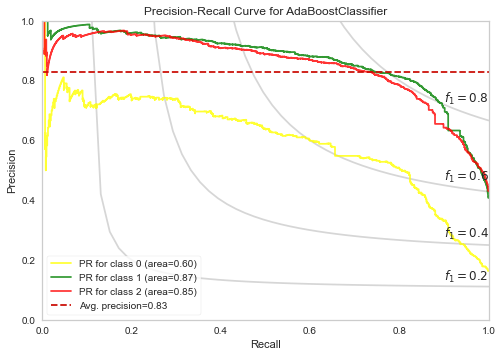

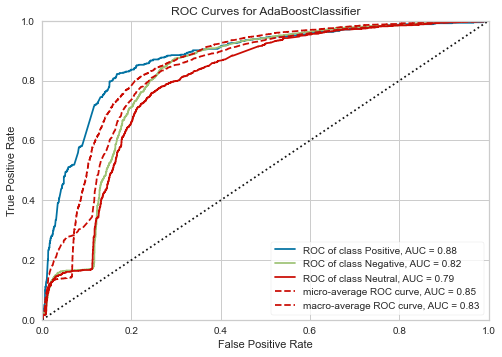

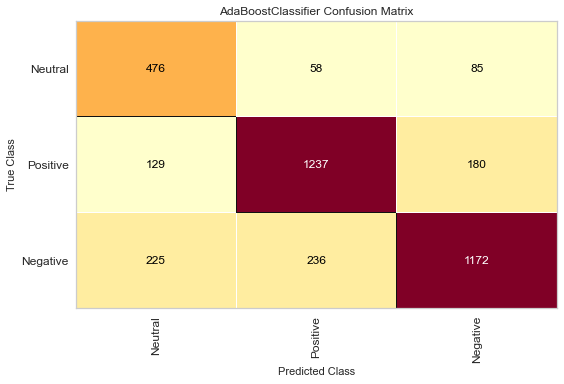

In [53]:
#Creating another model as AdaBoostClassifier with parameters recommended by
#Gridsearch.

ada_clf = AdaBoostClassifier(n_estimators = 600, learning_rate = 1)
ada_clf.fit(Train_features, Train_labels)
get_metrics(ada_clf, Train_features,Train_labels, Test_features, Test_labels)
get_precision_curves(ada_clf, Train_features,Train_labels, Test_features, Test_labels)
get_ROC_curves(ada_clf, Train_features,Train_labels, Test_features, Test_labels)
get_confusion_matrix(ada_clf, Train_features, Train_labels, Test_features, Test_labels)

## MODELS FEATURE TYPE 2

In [54]:
#Creating a TF-IDF vectorizer and fitting it to the training features. The test features
#are transformed against this. The columns are, however, now limited to 500.

vectorizer = TfidfVectorizer(sublinear_tf = True, min_df = 5, lowercase = False, max_features = 500)

Train_features = vectorizer.fit_transform(train_set['OriginalTweet'].astype(str))
Train_labels = train_set['Sentiment']

Test_features = vectorizer.transform(test_set['OriginalTweet'].astype(str))
Test_labels = test_set['Sentiment']

#### Gaussian Naive Bayes

GaussianNB()
Test F1 score = 0.5734896741019128
Train F1 score = 0.6092114250425419
Accuracy score = 0.5589784096893101
Precision score = 0.6350764296535768
Recall score = 0.5589784096893101



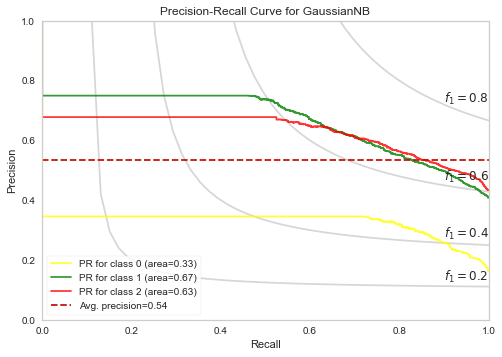

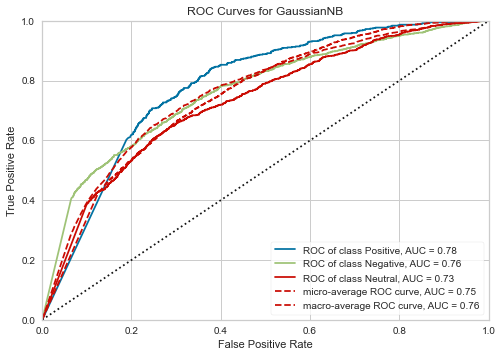

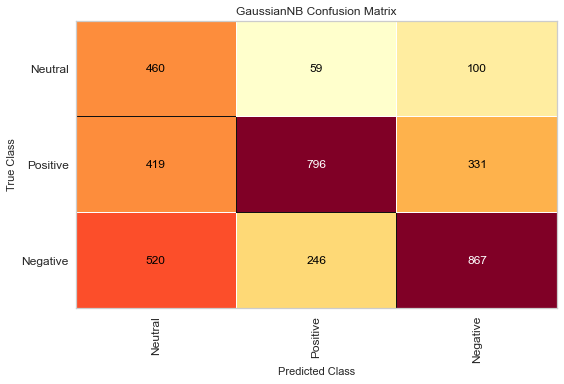

In [55]:
#Creating a Gaussian naive Bayes classifier

gaussian_clf = GaussianNB()
gaussian_clf.fit(Train_features.toarray(), Train_labels)
get_metrics(gaussian_clf, Train_features.toarray(),Train_labels, Test_features.toarray(), Test_labels)
get_precision_curves(gaussian_clf, Train_features.toarray(),Train_labels, Test_features.toarray(), Test_labels)
get_ROC_curves(gaussian_clf, Train_features.toarray(),Train_labels, Test_features.toarray(), Test_labels)
get_confusion_matrix(gaussian_clf, Train_features.toarray(), Train_labels, Test_features.toarray(), Test_labels)

#### Multinomial Naive Bayes Classifier

MultinomialNB(alpha=3, fit_prior=False)
Test F1 score = 0.6135445837092627
Train F1 score = 0.6352267652245712
Accuracy score = 0.6016324381253291
Precision score = 0.6481502126395019
Recall score = 0.6016324381253291



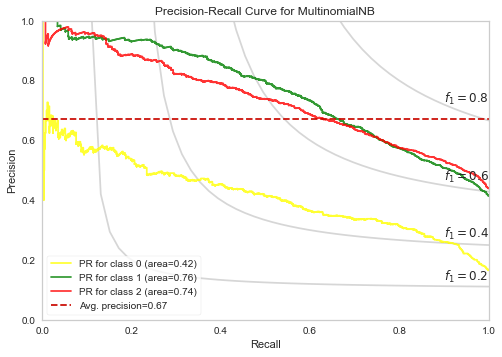

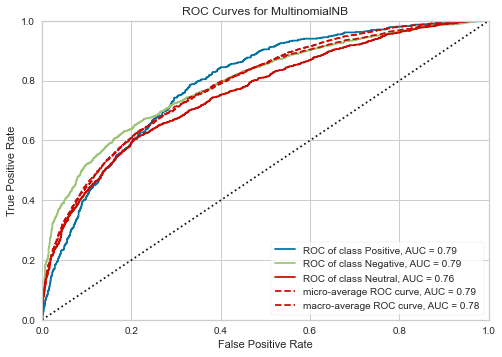

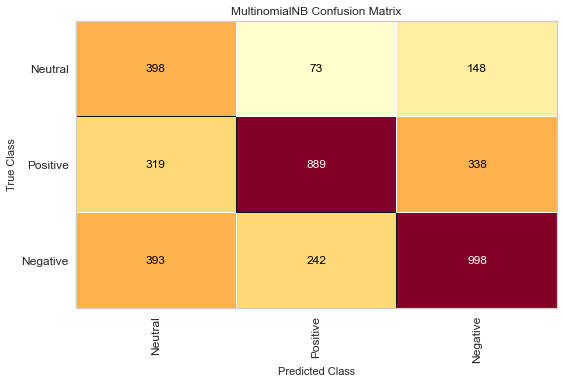

In [56]:
#Creating another model as MultinomialNB that is fitted with the recommended parameters
#obtained from Gridsearch.

multinomial_clf = MultinomialNB(alpha = 3, fit_prior= False)
multinomial_clf.fit(Train_features, Train_labels)
get_metrics(multinomial_clf, Train_features,Train_labels, Test_features, Test_labels)
get_precision_curves(multinomial_clf, Train_features,Train_labels, Test_features, Test_labels)
get_ROC_curves(multinomial_clf, Train_features,Train_labels, Test_features, Test_labels)
get_confusion_matrix(multinomial_clf, Train_features, Train_labels, Test_features, Test_labels)

#### AdaBoost Classifier

AdaBoostClassifier(learning_rate=1, n_estimators=600)
Test F1 score = 0.6393781057715278
Train F1 score = 0.6825470931657367
Accuracy score = 0.6395471300684571
Precision score = 0.6393752713268923
Recall score = 0.6395471300684571



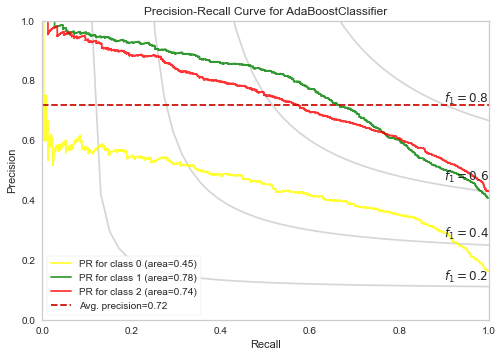

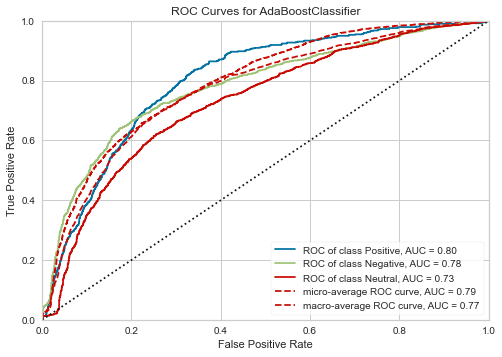

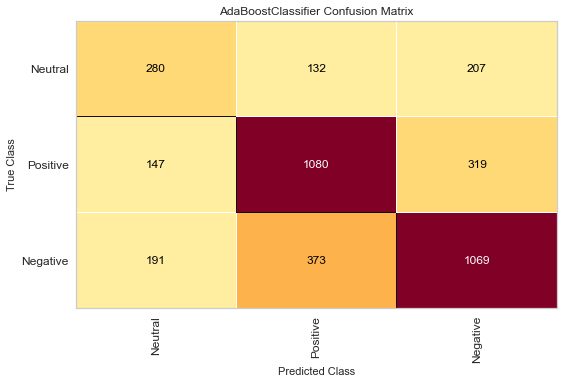

In [57]:
#Creating another model as AdaBoostClassifier with parameters recommended by
#Gridsearch.

ada_clf = AdaBoostClassifier(n_estimators = 600, learning_rate = 1)
ada_clf.fit(Train_features, Train_labels)
get_metrics(ada_clf, Train_features,Train_labels, Test_features, Test_labels)
get_precision_curves(ada_clf, Train_features,Train_labels, Test_features, Test_labels)
get_ROC_curves(ada_clf, Train_features,Train_labels, Test_features, Test_labels)
get_confusion_matrix(ada_clf, Train_features, Train_labels, Test_features, Test_labels)